## Web Scraping Guide for APHL Bioinformatics Fellowship
### Author: Bryce Asay (github name: paleomaniac)
### Date: 12/10/2020

Recently on Amazon I have been noticing a discrepancy of what Amazon says the users total review scores are and what I am seeing empirically. So, this will be a user guide to webs scraping while answering a real-world problem. 

Web scraping is different from a web crawler, but often you will hear the two terms used interchangeably. A Web crawler, or indexing, is done on a large scale and yields generic information by indexing the items on a page (aka how Googlebot works). Web scraping is done on any scale and is an automated way to extract from a website using scrapers.

Our test subject will be Amazon's Ring Doorbell, as you can see below the overall user score is a 4.6/5. 

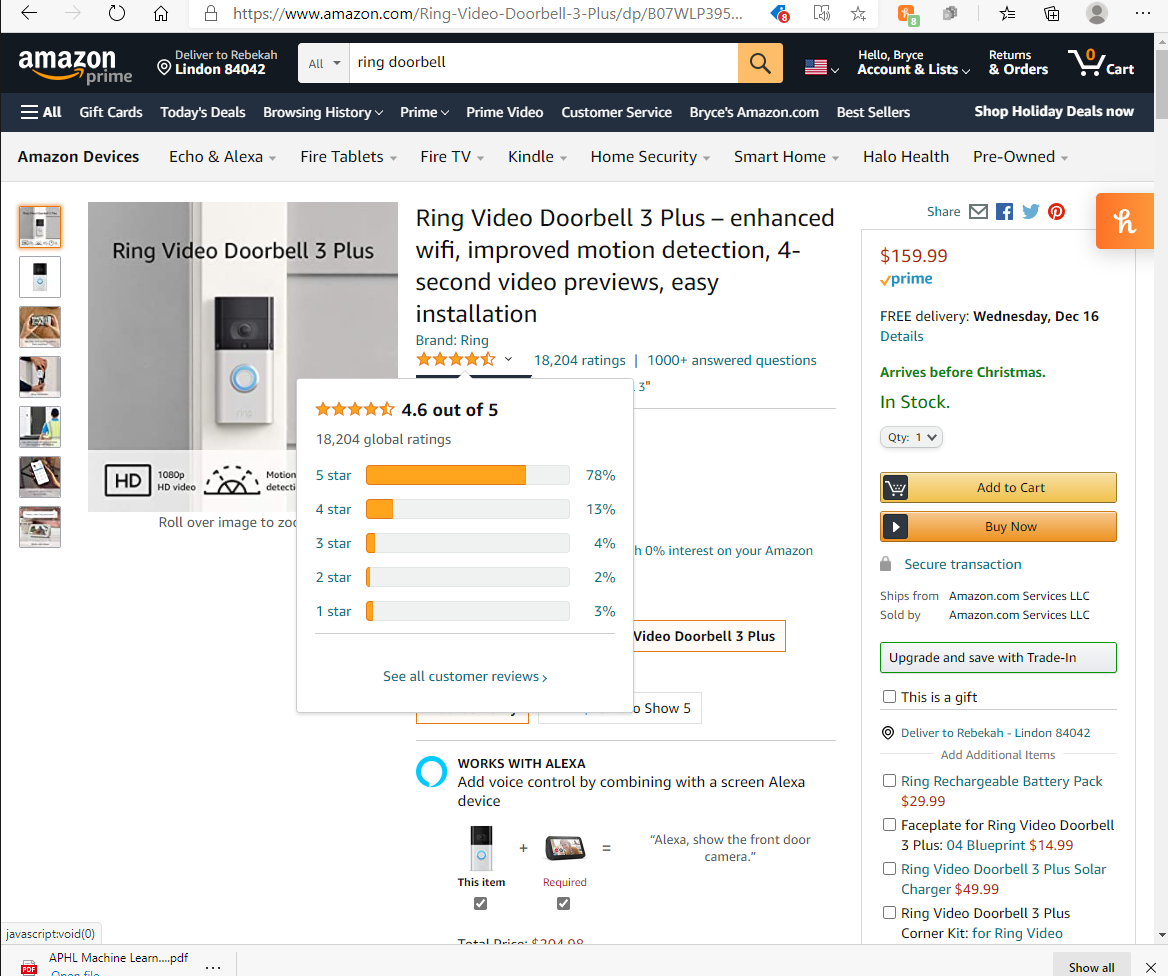

In [3]:
from IPython.display import Image,display
display(Image(filename="Amazon_ringdoorbell_review.png"))

While initially this seems good when we scroll down just a little further (image below text) we see a sea of 1 stars, sometimes for pages. We are going to create a web scraper to pull out all the amazon reviews and determine if Amazon is doctoring their overall score to entice buyers. We will be following the instructions outlined through scrape hero to make our code (https://www.scrapehero.com/how-to-scrape-amazon-product-reviews/)

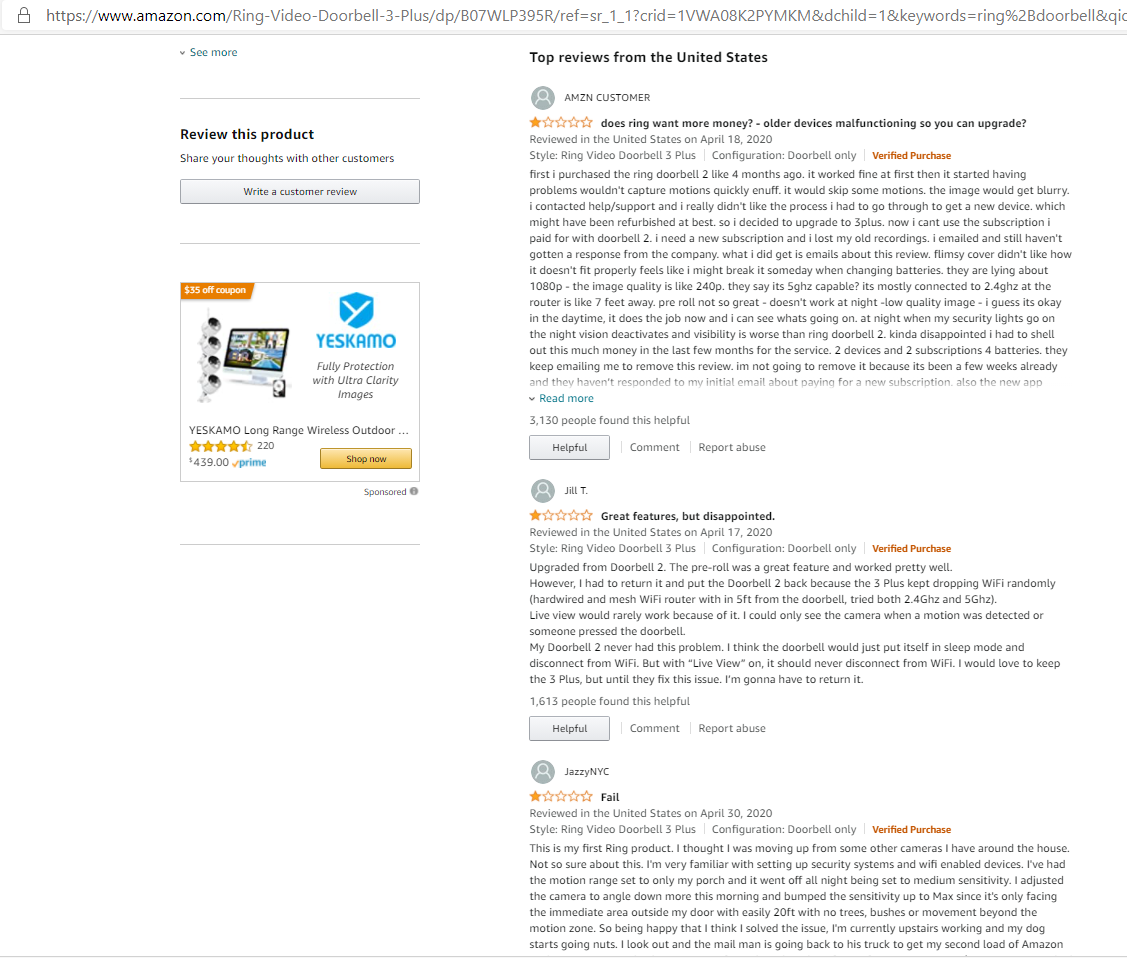

In [4]:
display(Image(filename="Amazon_ringdoorbell_fail.png"))

A web scraper is setup in 4 different parts. 
1) downloading the contents of a page, <br>
2) extracting the data, <br>
3) Storing the Data, <br>
4) Analyzing the data. <br> <br>
In this tutorial we will be using both selectorlib and requests to scrape the website. There a lot of different libraries including BeautifulSoup and Urllib3 that are also worth looking into. I generally use Urllib3 to request the raw data and BeautifulSoup to parse the data. However, for this example this seemed like the optimal method. 

### Import Libraries
These are the libraries required to run the code, make sure that they are downloaded with your distribution platform of choice.

In [5]:
from selectorlib import Extractor
import requests 
import json 
from time import sleep
import csv
from dateutil import parser as dateparser

## __Download and Extract the Web Data__

### Creating a YAML File

The selectorlib library requires a .yml with the information that will be required. Below is an example of the YAML file that we will be using for Amazon: <br> <br>
product_title:<br>
   > css: 'h1 a[data-hook="product-link"]'<br>
   > type: Text<br>
 
 reviews:<br>
   > css: 'div.review div.a-section.celwidget'<br>
   > multiple: true
   > type: Text
   > children:
   >>     title:
   >>         css: a.review-title
   >>         type: Text
   >     content:
   >>         css: 'div.a-row.review-data span.review-text'
   >>         type: Text
   >     date:
   >>         css: span.a-size-base.a-color-secondary
   >>         type: Text
   >     variant:
   >>         css: 'a.a-size-mini'
   >>         type: Text
   >     images:
   >>         css: img.review-image-tile
   >>         multiple: true
   >>         type: Attribute
   >>         attribute: src
   >     verified:
   >>         css: 'span[data-hook="avp-badge"]'
   >>         type: Text
   >     author:
   >>         css: span.a-profile-name
   >>         type: Text
   >     rating:
   >>         css: 'div.a-row:nth-of-type(2) > a.a-link-normal:nth-of-type(1)'
   >>         type: Attribute
   >>         attribute: title

next_page:<br>
   > css: 'li.a-last a'<br>
   > type: Link<br>
<br><br>

Because each page is different you will have to customize this for the information that you need. You most likely won't know what element markdown is needed to extract the desired data. To get around this there is a chrome extension for selectorlib that will help you create the .yml file. All you have to do is select the elements you want and export the highlighted sections on the website to generate the YAML file. For this particular example the YAML file is shown above. Here is more information on how to use it here (https://www.scrapehero.com/how-to-scrape-amazon-product-reviews/)

Using headers greatly reduces the chances that a website might block you from scraping their website and that the data is of high quality. Here are some of the common headers used in web scraping: <br>
1) __User Agent__: will pass information on the user to the website (e.g. application type, operating system, software, and version) <br>
2) __Accept language__: select which language should be displayed on the website <br>
3) __Accept__: informs the web server on that type of data format is returned to the client <br>



In [6]:

# Create an Extractor by reading from the YAML file
e = Extractor.from_yaml_file('selectors.yml')

def scrape(url):    
    # the scrape function will access the webserver and return the requested information as text 
    headers = {
        'authority': 'www.amazon.com',
        'pragma': 'no-cache',
        'cache-control': 'no-cache',
        'dnt': '1',
        'upgrade-insecure-requests': '1',
        'user-agent': 'Mozilla/5.0 (X11; CrOS x86_64 8172.45.0) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/51.0.2704.64 Safari/537.36',
        'accept': 'text/html,application/xhtml+xml,application/xml;q=0.9,image/webp,image/apng,*/*;q=0.8,application/signed-exchange;v=b3;q=0.9',
        'sec-fetch-site': 'none',
        'sec-fetch-mode': 'navigate',
        'sec-fetch-dest': 'document',
        'accept-language': 'en-GB,en-US;q=0.9,en;q=0.8',
    }

    # Download the page using requests
    print("Downloading %s"%url)
    r = requests.get(url, headers=headers)
    # Simple check to check if page was blocked (Usually 503)
    if r.status_code > 500:
        if "To discuss automated access to Amazon data please contact" in r.text:
            print("Page %s was blocked by Amazon. Please try using better proxies\n"%url)
        else:
            print("Page %s must have been blocked by Amazon as the status code was %d"%(url,r.status_code))
        return None
    # Pass the HTML of the page and create 
    return e.extract(r.text)



## __Store the Results__
We will be storing the results as a csv. For my computer I had to specify the csv encoding as a 'utf-8' to make it work.  

Now that we have a function to extract the data from the web server, we will use it in practice. For this particular example I clicked on show all reviews and copied the url on that particular page. The way that Amazon has this setup is that end of their url is Type=all_reviews&pageNumber=. I created a for loop to collect all pages of reviews by filling in the last part of the URL with the page number, for the ring doorbelll 3+ there was 106 pages of review at the time this tutorial was created. <br><br>

In [ ]:
with open('data.csv','w', encoding='utf-8', errors='ignore') as outfile:
    writer = csv.DictWriter(outfile, fieldnames=["title","content","date","variant","images","verified","author","rating","product","url"],quoting=csv.QUOTE_ALL)
    writer.writeheader()
    for page_num in range(106):
        url = 'https://www.amazon.com/Ring-Video-Doorbell-3-Plus/product-reviews/B07WLP395R/ref=cm_cr_arp_d_paging_btm_next_2?ie=UTF8&reviewerType=all_reviews&pageNumber={}'.format(str(page_num))
        data = scrape(url) 
        if data:
            for r in data['reviews']:
                r["product"] = data["product_title"]
                r['url'] = url
                if 'verified' in r:
                    if 'Verified Purchase' in r['verified']:
                        r['verified'] = 'Yes'
                    else:
                        r['verified'] = 'Yes'
                r['rating'] = r['rating'].split(' out of')[0]
                date_posted = r['date'].split('on ')[-1]
                if r['images']:
                    r['images'] = "\n".join(r['images'])
                r['date'] = dateparser.parse(date_posted).strftime('%d %b %Y')
                writer.writerow(r)
        # sleep(5)

## __Analyze the Data__

### Import the Libraries
We will be using numpy, pandas, scipy, and matplotlib to do our data analysis

In [7]:
import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns

In [8]:
df = pd.read_csv('data.csv')

### The process of analysis
First, I want to verify that my csv file was correctly generated and that there are not any immediate issues that need to be resolved. I will do this by first looking at a section of the data frame which will be followed by getting summary statistics including the means and rating counts. 

In [9]:
print(df.head())


                                               title  \
0  does ring want more money? - older devices mal...   
1                  Great features, but disappointed.   
2                                               Fail   
3                  So much better than the original.   
4           Great potential — but Launched with Bugs   

                                             content         date  \
0  first i purchased the ring doorbell 2 like 4 m...  18 Apr 2020   
1  Upgraded from Doorbell 2. The pre-roll was a g...  17 Apr 2020   
2  This is my first Ring product. I thought I was...  30 Apr 2020   
3  Cheaped out the first time and got the origina...  29 Jun 2020   
4  Was super excited to Finally get this doorbell...  11 Apr 2020   

                                             variant  \
0  Style: Ring Video Doorbell 3 Plus Configuratio...   
1  Style: Ring Video Doorbell 3 Plus Configuratio...   
2  Style: Ring Video Doorbell 3 Plus Configuratio...   
3  Style: Ring Video Doo

In [10]:
print("Description")
print(df.describe())
print("\nRating Counts")
print(df['rating'].value_counts())

Description
            rating
count  1060.000000
mean      3.612264
std       1.613107
min       1.000000
25%       2.000000
50%       4.000000
75%       5.000000
max       5.000000

Rating Counts
5.0    523
1.0    212
4.0    120
3.0    112
2.0     93
Name: rating, dtype: int64


So immediately the first thing I notice is that the mean is a whole rating lower than what Amazon indicated. I am surprised though at how many 5 and 1 stars are present, it seems that people either liked the product or hated it. While it is tempting to assume our job is done when you need to do some investigating at possible reasons for the difference from the reported Amazon score. My next though is to graph the data frame using both a line and hist plot to see if we can see anything. My initial thought is maybe reviews change overtime and maybe the most recent reviews are more positive than the earlier reviews. This might be a justifiable reason to weight the average score on what individuals are saying about the project now. 

<AxesSubplot:>

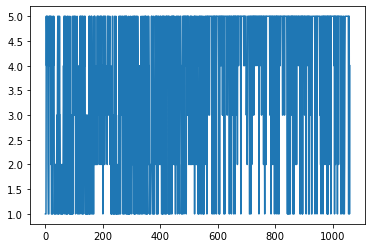

In [11]:
df['rating'].plot()

<AxesSubplot:ylabel='Frequency'>

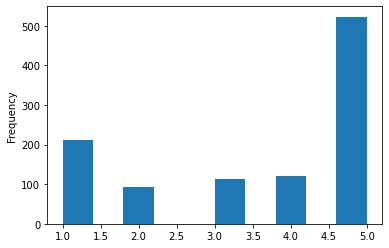

In [12]:
df['rating'].plot.hist()

The histogram shows the rating score frequencies as shown previously but the line graph is a mess. Let’s see if we can clean it up a little bit. First, let’s convert the date into a more user-friendly format for plotting. One of the things I will be doing is converting the current Day Month Year format into the more acceptable Year-Month-Day format instead.

In [1]:
#I used this to know how the date format was assigned for each month
#for month in df['date']:
    #if '' in month:
        #print(month)

In [13]:
month_conv = {'Jan':1,'Feb':2, 'Mar':3, 'Apr':4, 'May':5, 'Jun':6, 'Jul':7, 
              'Aug':8, 'Sep':9, 'Oct':10, 'Nov':11, 'Dec':12}

In [14]:
clean_date = []
for date in df['date']:
    x = []
    split_date = date.split()
    clean_date.append(split_date[2]+'-'+str(month_conv[split_date[1]])+'-'+split_date[0])
#print(clean_date)

In [15]:
df['clean_date']=pd.to_datetime(clean_date)
df['clean_date2']=pd.to_datetime(clean_date)
print(df.head())

                                               title  \
0  does ring want more money? - older devices mal...   
1                  Great features, but disappointed.   
2                                               Fail   
3                  So much better than the original.   
4           Great potential — but Launched with Bugs   

                                             content         date  \
0  first i purchased the ring doorbell 2 like 4 m...  18 Apr 2020   
1  Upgraded from Doorbell 2. The pre-roll was a g...  17 Apr 2020   
2  This is my first Ring product. I thought I was...  30 Apr 2020   
3  Cheaped out the first time and got the origina...  29 Jun 2020   
4  Was super excited to Finally get this doorbell...  11 Apr 2020   

                                             variant  \
0  Style: Ring Video Doorbell 3 Plus Configuratio...   
1  Style: Ring Video Doorbell 3 Plus Configuratio...   
2  Style: Ring Video Doorbell 3 Plus Configuratio...   
3  Style: Ring Video Doo

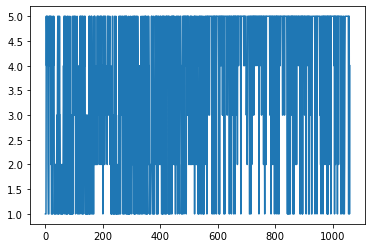

In [16]:
#df.set_index('clean_date2', inplace=True)
ax = df['rating'].plot()
plt.show()

This is not very informative, so let's aggregate the data by finding the means of each month and plotting that instead. The first thing we need to do is find out more about the date range, create a new month column, calculate the mean for each month, and plot it as we did before. 

In [17]:
print(df['clean_date'].min())
print(df['clean_date'].max())

2020-04-10 00:00:00
2020-12-11 00:00:00


In [19]:
#Add a new column to include the months for easy parsing
df['month']= pd.DatetimeIndex(df['clean_date']).month
print(df.head())

                                               title  \
0  does ring want more money? - older devices mal...   
1                  Great features, but disappointed.   
2                                               Fail   
3                  So much better than the original.   
4           Great potential — but Launched with Bugs   

                                             content         date  \
0  first i purchased the ring doorbell 2 like 4 m...  18 Apr 2020   
1  Upgraded from Doorbell 2. The pre-roll was a g...  17 Apr 2020   
2  This is my first Ring product. I thought I was...  30 Apr 2020   
3  Cheaped out the first time and got the origina...  29 Jun 2020   
4  Was super excited to Finally get this doorbell...  11 Apr 2020   

                                             variant  \
0  Style: Ring Video Doorbell 3 Plus Configuratio...   
1  Style: Ring Video Doorbell 3 Plus Configuratio...   
2  Style: Ring Video Doorbell 3 Plus Configuratio...   
3  Style: Ring Video Doo

In [20]:
df_means = df.groupby(['month'])['rating'].mean()
print(df_means)

month
4     3.764706
5     3.655172
6     3.827957
7     3.768293
8     3.449541
9     3.858209
10    3.708108
11    3.291667
12    3.530435
Name: rating, dtype: float64


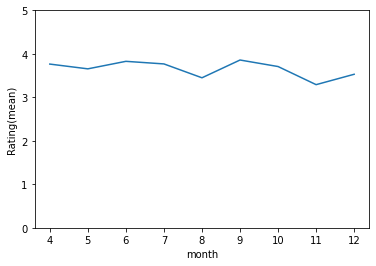

In [21]:
ax = df_means.plot()
ax.set_yticks([0,1,2,3,4,5])
plt.ylabel('Rating(mean)')
plt.show()

## Conclusion
Based upon the final analysis above I would argue that the real score for the Ring Doorbell is actually a 3.6 not a 4.6. This is supported by the monthly average shown above in the graph. Well I hope this was informative on the web scraping process and please contact Bryce Asay if you have any questions!